# **AlphaCom Customer Churn Prediction**
**Objective:** Develop a predictive model to identify customers at high risk of churn and uncover the key factors driving their decisions.

# 1. Setup and Import Libraries

First, we will import all the necessary libraries for data manipulation, visualization, and machine learning.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
import re

# Set plotting style
sns.set_style('whitegrid')

In [2]:
# Helper function for plotting confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    """Plots a styled confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        cbar=False,
        annot_kws={'size': 14}
    )
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title(f'Confusion Matrix: {model_name}', fontsize=14)
    plt.show()

print("Libraries imported and helper function defined.")

Libraries imported and helper function defined.



# 2. Load and Deeply Inspect Data

Load the data and perform a deep inspection to identify all data quality issues.
Load the dataset from the uploaded file path
In Colab, we would upload the file to your session storage first.

In [3]:
file_path = '/content/drive/MyDrive/customer_churn.csv'
df = pd.read_csv(file_path)

# Display the first 5 rows to see formatting
print("--- First 5 Rows (Raw) ---")
print(df.head())

# Display data types and non-null counts
print("\n--- Data Info (Raw) ---")
df.info()

--- First 5 Rows (Raw) ---
   gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  Female              0     Yes         No     1.0           No   
1    Male              0      No         No    34.0          Yes   
2    Male              0      No         No     2.0          Yes   
3    Male              0      No         No    45.0           No   
4  Female              0      No         No     2.0          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1    

#3. Data Cleaning and Preparation

Systematically fix all identified issues:
1.  Clean monetary columns (`MonthlyCharges`, `TotalCharges`).
2.  Fix invalid `tenure` values.
3.  Standardize all categorical columns.
4.  Map target variable `Churn`.
5.  Standardize "No service" entries.
6.  Convert `SeniorCitizen` to a string for proper encoding.
7.  Drop duplicates and other invalid rows.


In [4]:
# Create a copy for cleaning
df_clean = df.copy()

### 1. Clean Monetary Columns: MonthlyCharges and TotalCharges

In [5]:
print("--- Cleaning Monetary Columns ---")
for col in ['MonthlyCharges', 'TotalCharges']:
    # Remove '$' and any whitespace, then convert to numeric
    # errors='coerce' will turn any problematic values (like 'nan' string) into np.nan
    df_clean[col] = pd.to_numeric(
        df_clean[col].astype(str).str.replace(r'[$,\s]', '', regex=True),
        errors='coerce'
    )
print("Converted 'MonthlyCharges' and 'TotalCharges' to numeric, coercing errors to NaN.")

--- Cleaning Monetary Columns ---
Converted 'MonthlyCharges' and 'TotalCharges' to numeric, coercing errors to NaN.


### 2. Fix Invalid 'tenure' Values

In [6]:
invalid_tenure_count = df_clean[df_clean['tenure'] < 0].shape[0]
if invalid_tenure_count > 0:
    print(f"Found {invalid_tenure_count} rows with tenure < 0. Replacing with 0.")
    df_clean['tenure'] = df_clean['tenure'].apply(lambda x: 0 if x < 0 else x)

Found 127 rows with tenure < 0. Replacing with 0.


### 3. Clean ALL Categorical (Object) Columns

In [7]:
print("\n--- Standardizing Categorical Columns ---")
object_cols = df_clean.select_dtypes('object').columns
for col in object_cols:
    df_clean[col] = df_clean[col].str.strip().str.lower()
print(f"Standardized {len(object_cols)} object columns.")


--- Standardizing Categorical Columns ---
Standardized 16 object columns.


### 4. Standardize Target Variable 'Churn'

In [8]:
df_clean['Churn'] = df_clean['Churn'].map({'yes': 1, 'no': 0})
# Drop rows where Churn is NaN (from bad data)
nan_churn = df_clean['Churn'].isnull().sum()
if nan_churn > 0:
    print(f"Dropping {nan_churn} rows with invalid 'Churn' values.")
    df_clean = df_clean.dropna(subset=['Churn'])
df_clean['Churn'] = df_clean['Churn'].astype(int)


### 5. Standardize "Yes/No/No service" columns

In [9]:
cols_to_standardize = [
    'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies'
]
for col in cols_to_standardize:
    df_clean[col] = df_clean[col].replace(
        {'no internet service': 'no', 'no phone service': 'no'}
    )
print("Standardized 'no ... service' values to 'no'.")

Standardized 'no ... service' values to 'no'.


### 6. Convert 'SeniorCitizen' to object for correct encoding

In [10]:
df_clean['SeniorCitizen'] = df_clean['SeniorCitizen'].astype(str)

### 7. Drop duplicates and invalid rows

In [11]:
duplicates = df_clean.duplicated().sum()
if duplicates > 0:
    df_clean = df_clean.drop_duplicates()
    print(f"\nDropped {duplicates} duplicate rows.")
else:
    print("\nNo duplicate rows found.")

# Drop rows where MonthlyCharges is 0 (likely invalid data)
zero_monthly = df_clean[df_clean['MonthlyCharges'] == 0].shape[0]
if zero_monthly > 0:
    print(f"Found and dropped {zero_monthly} rows with MonthlyCharges == 0.")
    df_clean = df_clean[df_clean['MonthlyCharges'] > 0]


Dropped 27 duplicate rows.


### 8. Final Data Check

In [12]:
print("\n--- Data Info (After Cleaning) ---")
df_clean.info()
print("\n--- Missing Values (After Cleaning) ---")
print(df_clean.isnull().sum())


--- Data Info (After Cleaning) ---
<class 'pandas.core.frame.DataFrame'>
Index: 12028 entries, 0 to 12042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            12028 non-null  object 
 1   SeniorCitizen     12028 non-null  object 
 2   Partner           12028 non-null  object 
 3   Dependents        12028 non-null  object 
 4   tenure            11426 non-null  float64
 5   PhoneService      12028 non-null  object 
 6   MultipleLines     12028 non-null  object 
 7   InternetService   12028 non-null  object 
 8   OnlineSecurity    12028 non-null  object 
 9   OnlineBackup      12028 non-null  object 
 10  DeviceProtection  12028 non-null  object 
 11  TechSupport       12028 non-null  object 
 12  StreamingTV       12028 non-null  object 
 13  StreamingMovies   12028 non-null  object 
 14  Contract          12028 non-null  object 
 15  PaperlessBilling  12028 non-null  object 
 16  PaymentMe

#4. Feature Engineering

Create a `TenureGroup` for easier visualization in EDA. This column will be used for plotting only, not for model training.


In [13]:
# Bin tenure into groups. We use -1 to include 0 in the first bin.
tenure_bins = [-1, 12, 24, 36, 48, 60, 73] # 0-1yr, 1-2yr, ... 5+yr
tenure_labels = ['0-12 Mos', '13-24 Mos', '25-36 Mos', '37-48 Mos', '49-60 Mos', '61+ Mos']
df_clean['TenureGroup'] = pd.cut(
    df_clean['tenure'],
    bins=tenure_bins,
    labels=tenure_labels,
    right=True
)

print("Created 'TenureGroup' feature for EDA.")
print(df_clean['TenureGroup'].value_counts())

Created 'TenureGroup' feature for EDA.
TenureGroup
0-12 Mos     3842
61+ Mos      2220
13-24 Mos    1500
37-48 Mos    1356
25-36 Mos    1296
49-60 Mos    1206
Name: count, dtype: int64


# 5. Exploratory Data Analysis (EDA)


### Visualize the clean data to find patterns.

/tmp/ipython-input-3800829367.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Churn', data=df_clean, palette='pastel')


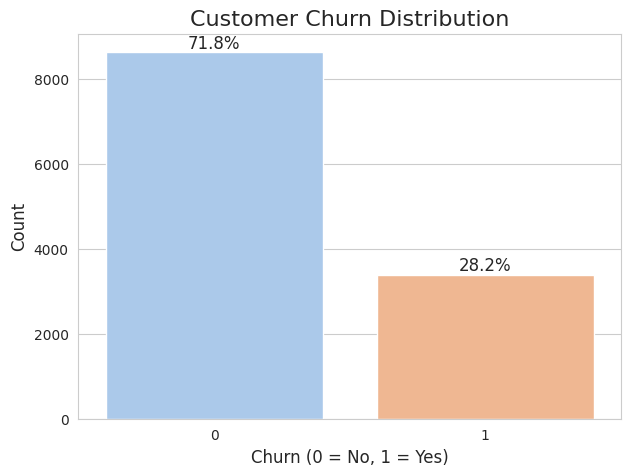

In [14]:
#5.1. Target Variable: Churn Distribution

plt.figure(figsize=(7, 5))
ax = sns.countplot(x='Churn', data=df_clean, palette='pastel')
plt.title('Customer Churn Distribution', fontsize=16)
plt.xlabel('Churn (0 = No, 1 = Yes)', fontsize=12)
plt.ylabel('Count', fontsize=12)
total = len(df_clean)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=12)
plt.show()

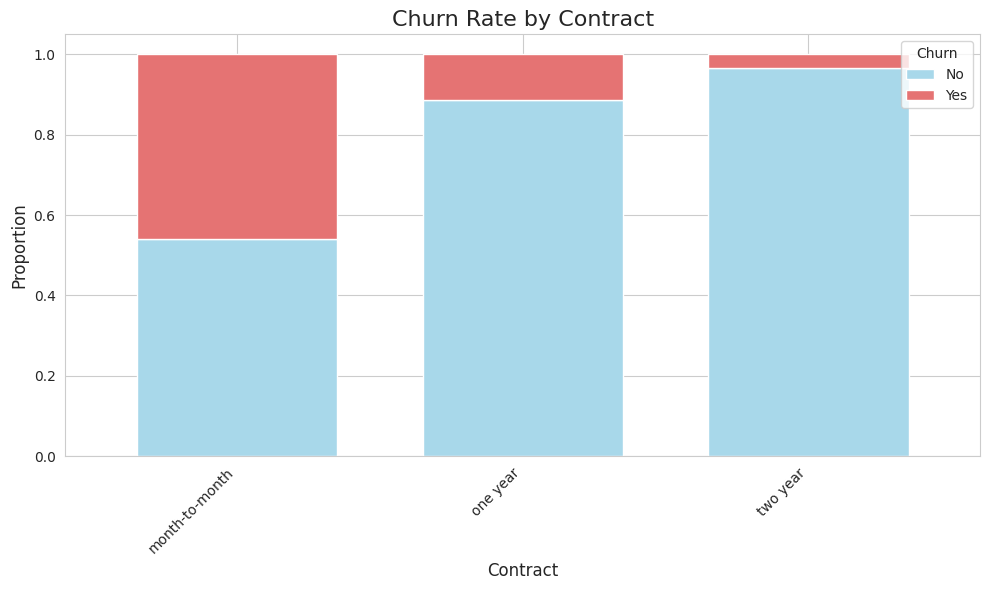

/tmp/ipython-input-2452539898.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prop_df = df_clean.groupby(col)['Churn'].value_counts(normalize=True).unstack().fillna(0)


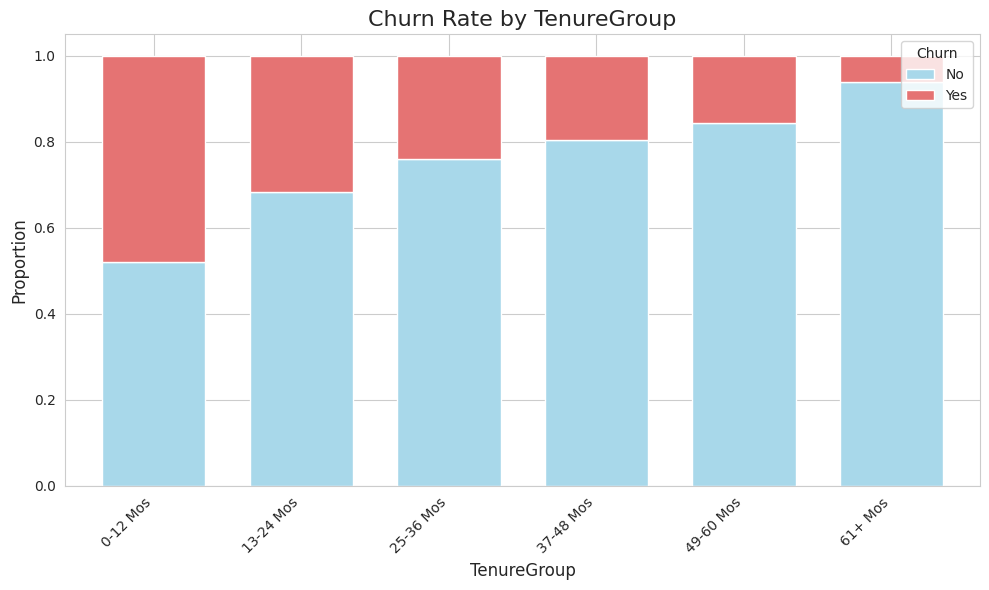

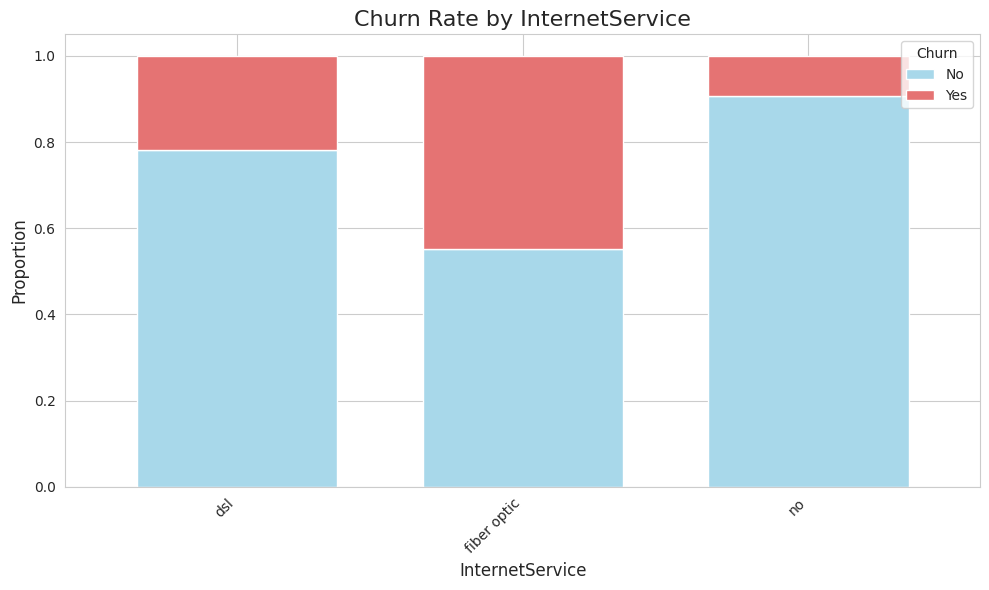

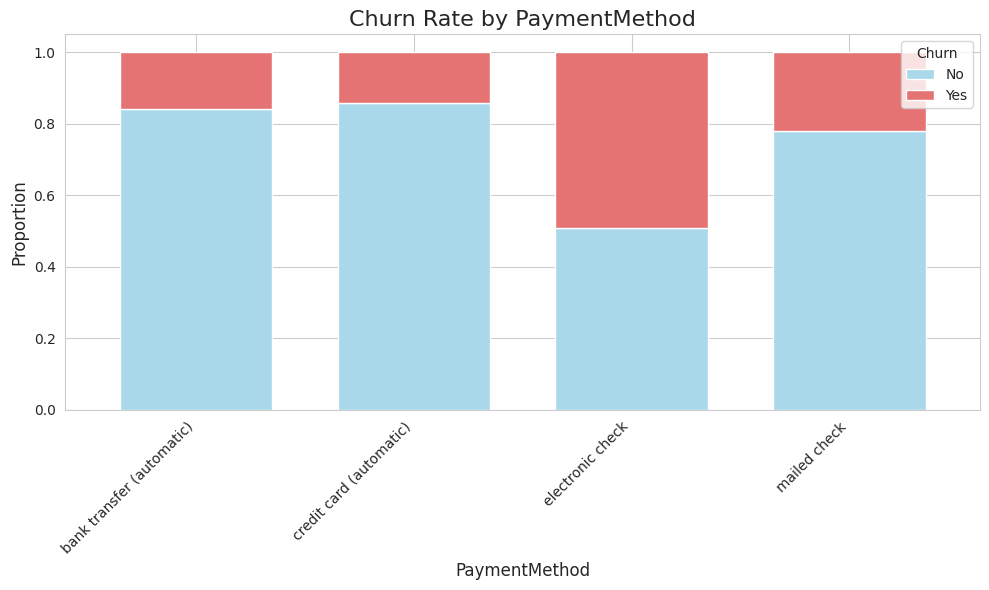

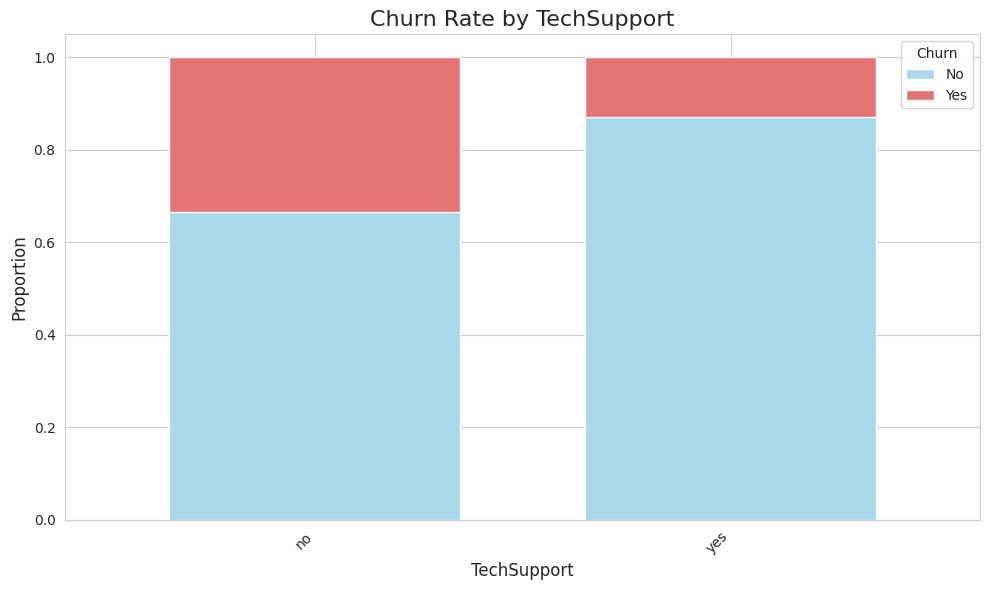

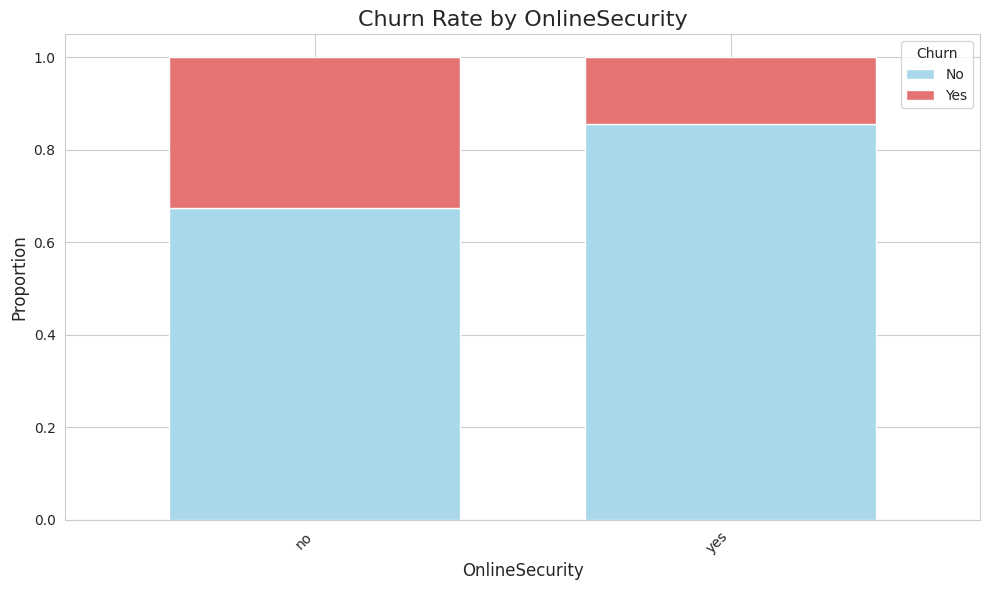

In [15]:
# 5.2. Categorical Features vs. Churn

key_cat_features = [
    'Contract',
    'TenureGroup',
    'InternetService',
    'PaymentMethod',
    'TechSupport',
    'OnlineSecurity'
]

for col in key_cat_features:
    # Calculate proportions. We remove observed=True to fix the plot error.
    prop_df = df_clean.groupby(col)['Churn'].value_counts(normalize=True).unstack().fillna(0)

    prop_df.plot(
        kind='bar',
        stacked=True,
        figsize=(10, 6),
        color=['#a8d8ea', '#e57373'],
        width=0.7
    )

    plt.title(f'Churn Rate by {col}', fontsize=16)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Proportion', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Churn', labels=['No', 'Yes'], loc='upper right')
    plt.tight_layout()
    plt.show()

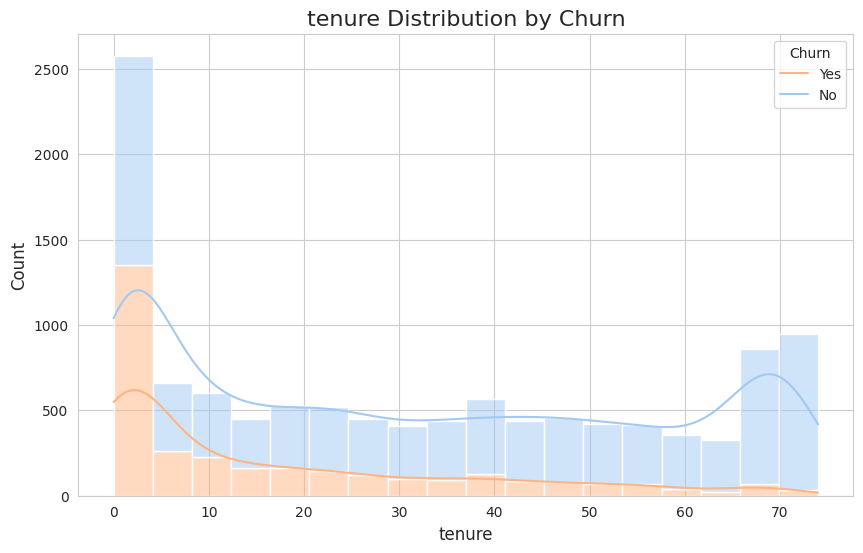

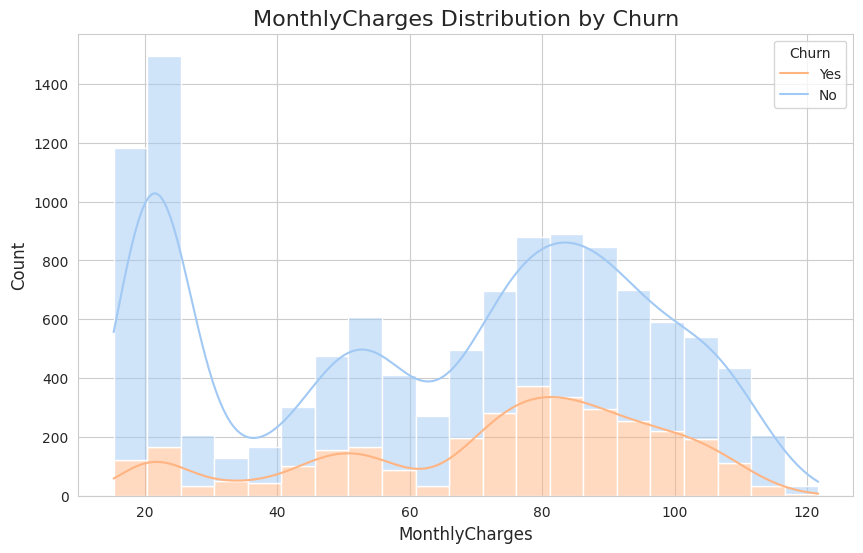

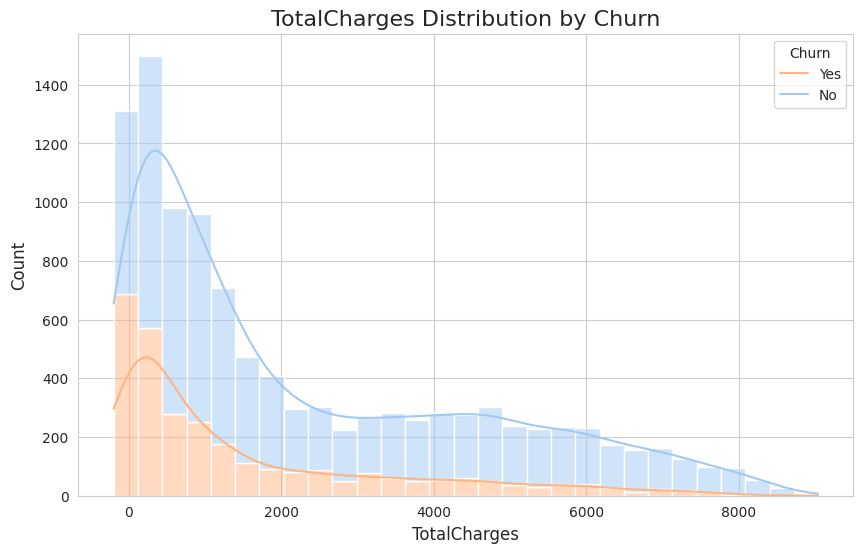

In [25]:
# 5.3. Numerical Features vs. Churn

num_features_for_eda = ['tenure', 'MonthlyCharges', 'TotalCharges']

for col in num_features_for_eda:
    plt.figure(figsize=(10, 6))
    sns.histplot(
        data=df_clean,
        x=col,
        hue='Churn',
        kde=True,
        multiple='stack',
        palette='pastel'
    )
    plt.title(f'{col} Distribution by Churn', fontsize=16)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.legend(title='Churn', labels=['Yes', 'No'])
    plt.show()

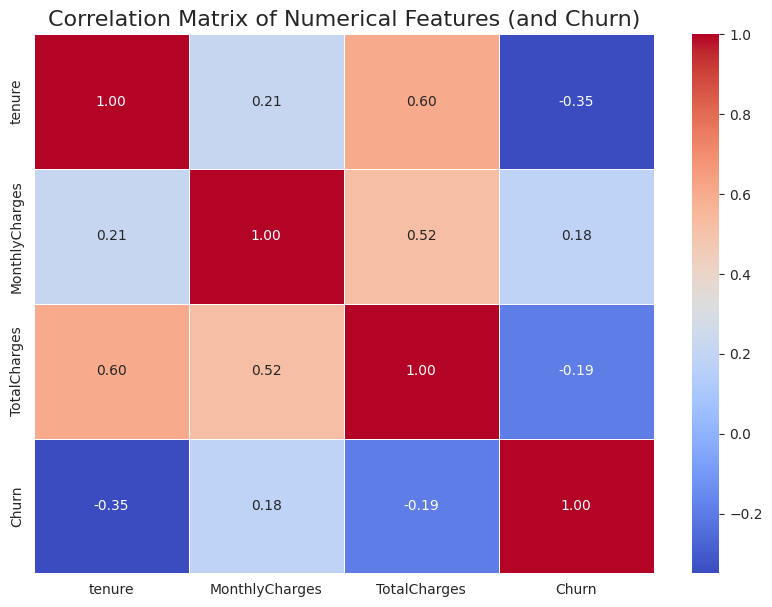

Generated correlation matrix heatmap.


In [27]:
# 5.4. Multivariate Analysis
# This section (added in v3) generates the correlation matrix heatmap to analyze relationships *between* numerical features and their relation to `Churn`.

df_numeric_plot = df_clean[num_features_for_eda + ['Churn']].copy()
df_numeric_plot['TotalCharges'] = df_numeric_plot['TotalCharges'].fillna(0)
df_numeric_plot['tenure'] = df_numeric_plot['tenure'].fillna(df_clean['tenure'].median())
df_numeric_plot['MonthlyCharges'] = df_numeric_plot['MonthlyCharges'].fillna(df_clean['MonthlyCharges'].median())


corr_matrix = df_numeric_plot.corr()

plt.figure(figsize=(10, 7))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    linewidths=0.5
)
plt.title('Correlation Matrix of Numerical Features (and Churn)', fontsize=16)
plt.show()
print("Generated correlation matrix heatmap.")

# 6. Feature Preprocessing & Pipeline

Prepare the data for modeling. This includes:
1.  Splitting data into training and testing sets.
2.  Creating a preprocessing pipeline that **imputes missing values** (like in `TotalCharges`) and scales/encodes features. This is the robust way to prevent `NaN` errors during model training.

In [17]:
# 1. Define X (features) and y (target)
y = df_clean['Churn']
X = df_clean.drop(['Churn', 'TenureGroup'], axis=1) # TenureGroup is for EDA only

In [18]:
# 2. Identify numeric and categorical columns
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_features = [col for col in X.columns if col not in numeric_features]

print(f"Numeric features: {numeric_features}")
print(f"Categorical features: {categorical_features}")

Numeric features: ['tenure', 'MonthlyCharges', 'TotalCharges']
Categorical features: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


In [19]:
# 3. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y # Essential for imbalanced data
)
print(f"\nTraining set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")


Training set shape: (9622, 19)
Test set shape: (2406, 19)


In [20]:
# 4. Create preprocessing pipelines with Imputers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Impute NaNs using the median
    ('scaler', StandardScaler())                    # Scale data
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Impute potential NaNs
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # One-hot encode
])

# Combine transformers into a single preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)
print("\nPreprocessing pipeline created successfully.")


Preprocessing pipeline created successfully.


# 7. Model Building & Evaluation

Now we'll build and evaluate two models: a simple, interpretable Logistic Regression and a more complex Random Forest.

Training Logistic Regression model...
Training complete.

--- Logistic Regression Classification Report ---
              precision    recall  f1-score   support

           0       0.90      0.76      0.83      1727
           1       0.57      0.79      0.66       679

    accuracy                           0.77      2406
   macro avg       0.74      0.78      0.74      2406
weighted avg       0.81      0.77      0.78      2406

ROC AUC Score: 0.8531


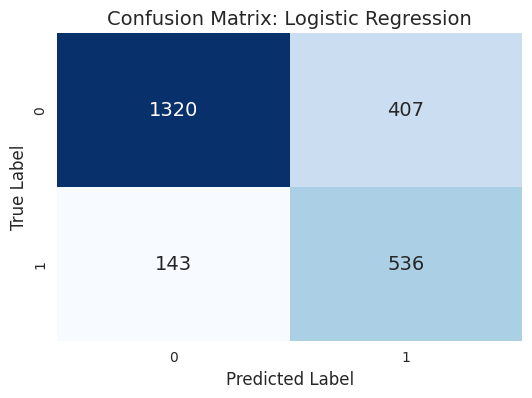

In [21]:
# 7.1. Model 1: Logistic Regression (Best Solution)

# Create the full pipeline: Preprocess -> Classify
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        random_state=42,
        solver='liblinear',
        class_weight='balanced' # Helps with imbalanced data
    ))
])

# Train the model
print("Training Logistic Regression model...")
lr_pipeline.fit(X_train, y_train)
print("Training complete.")

# Evaluate the model
y_pred_lr = lr_pipeline.predict(X_test)
y_prob_lr = lr_pipeline.predict_proba(X_test)[:, 1]

print("\n--- Logistic Regression Classification Report ---")
print(classification_report(y_test, y_pred_lr))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob_lr):.4f}")

plot_confusion_matrix(y_test, y_pred_lr, "Logistic Regression")

Training Random Forest model...
Training complete.

--- Random Forest Classification Report ---
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1727
           1       0.67      0.50      0.58       679

    accuracy                           0.79      2406
   macro avg       0.75      0.70      0.72      2406
weighted avg       0.78      0.79      0.78      2406

ROC AUC Score: 0.8323


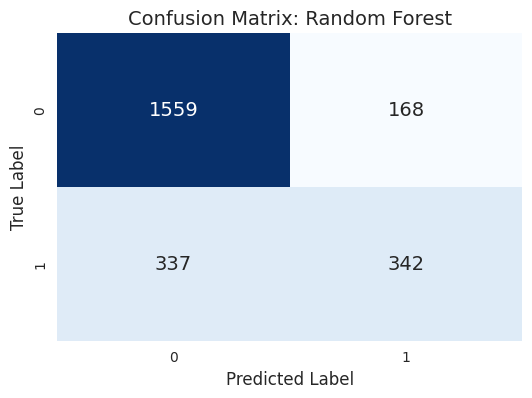

In [22]:
# 7.2. Model 2: Random Forest Classifier
# Create the full pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        random_state=42,
        n_estimators=100,
        class_weight='balanced' # Helps with imbalanced data
    ))
])

# Train the model
print("Training Random Forest model...")
rf_pipeline.fit(X_train, y_train)
print("Training complete.")

# Evaluate the model
y_pred_rf = rf_pipeline.predict(X_test)
y_prob_rf = rf_pipeline.predict_proba(X_test)[:, 1]

print("\n--- Random Forest Classification Report ---")
print(classification_report(y_test, y_pred_rf))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob_rf):.4f}")

plot_confusion_matrix(y_test, y_pred_rf, "Random Forest")


# 8. Model Comparison and Key Driver Analysis

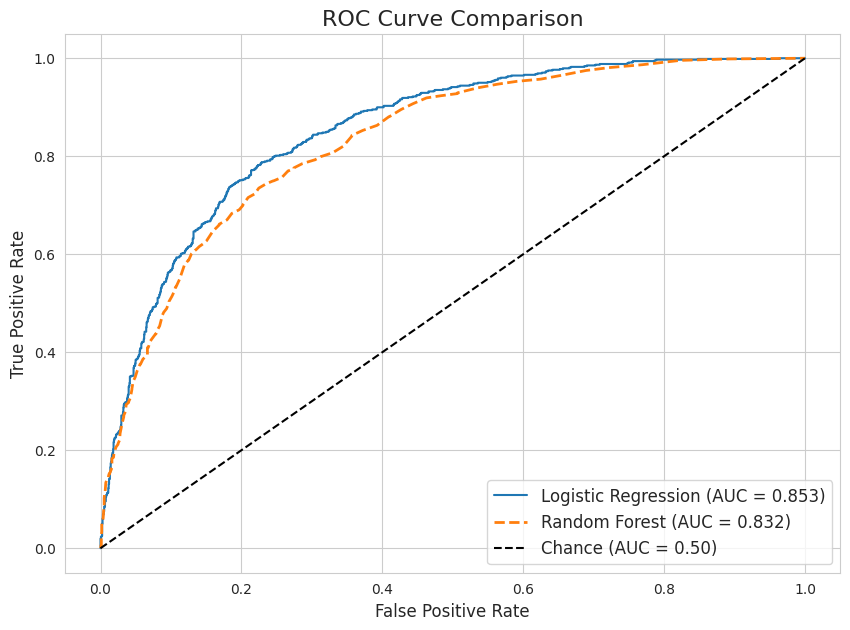

In [23]:
# 8.1. ROC Curve Comparison

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
auc_lr = roc_auc_score(y_test, y_prob_lr)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
auc_rf = roc_auc_score(y_test, y_prob_rf)

plt.figure(figsize=(10, 7))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.3f})', linewidth=2, linestyle='--')
plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.50)')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve Comparison', fontsize=16)
plt.legend(fontsize=12)
plt.show()


--- Top 20 Most Important Features (from Random Forest) ---
                           feature  importance
0                           tenure    0.138936
2                     TotalCharges    0.136600
1                   MonthlyCharges    0.134738
30         Contract_month-to-month    0.086549
32               Contract_two year    0.039716
37  PaymentMethod_electronic check    0.036257
16     InternetService_fiber optic    0.035642
17              InternetService_no    0.020786
25                 TechSupport_yes    0.019822
31               Contract_one year    0.017564
4                      gender_male    0.015518
3                    gender_female    0.015263
33             PaperlessBilling_no    0.015142
24                  TechSupport_no    0.015088
7                       Partner_no    0.013234
8                      Partner_yes    0.013203
34            PaperlessBilling_yes    0.013139
19              OnlineSecurity_yes    0.012823
23            DeviceProtection_yes    0.012348

/tmp/ipython-input-2220638711.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


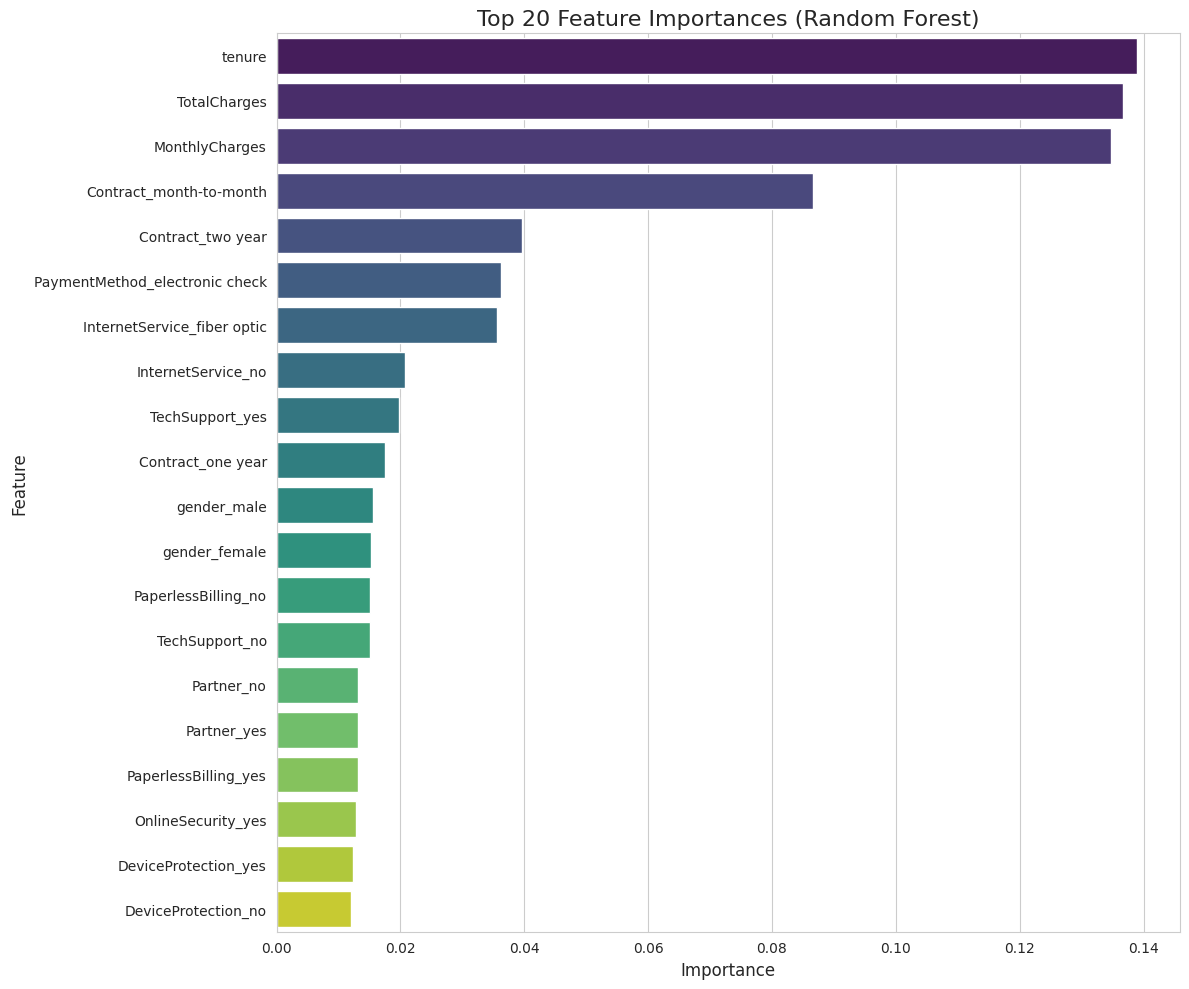

In [24]:
# 8.2. Key Churn Drivers (Feature Importance)
# We'll extract feature importances from the Random Forest model, as it can capture more complex relationships in the data.
# Get the trained model and preprocessor from the pipeline
rf_model = rf_pipeline.named_steps['classifier']
preprocessor_fitted = rf_pipeline.named_steps['preprocessor']

# Get feature names from the OneHotEncoder step
ohe_feature_names = preprocessor_fitted.named_transformers_['cat'] \
                    .named_steps['onehot'] \
                    .get_feature_names_out(categorical_features)

# Combine numeric and one-hot-encoded feature names
all_feature_names = np.concatenate([numeric_features, ohe_feature_names])

# Create a DataFrame of feature importances
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Display the top 20 features
print("\n--- Top 20 Most Important Features (from Random Forest) ---")
print(feature_importance_df.head(20))

# Plot the top 20 features
plt.figure(figsize=(12, 10))
sns.barplot(
    x='importance',
    y='feature',
    data=feature_importance_df.head(20),
    palette='viridis'
)
plt.title('Top 20 Feature Importances (Random Forest)', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

#9. Final Recommendations

Based on the **Logistic Regression model** (chosen for its superior recall) and the **Feature Importance analysis**:

1.  **Target Month-to-Month Customers:** Proactively reach out to all customers on `Month-to-month` contracts and offer them a small discount or perk to switch to a `One year` contract. This addresses a top churn driver.

2.  **Launch a New Customer Onboarding Program:** Since low `tenure` is the #1 risk factor, create a "white-glove" onboarding experience for all customers in their first 12 months to build loyalty.

3.  **Review Fiber Optic Pricing:** Investigate *why* `Fiber optic` and high `MonthlyCharges` (the #3 driver) lead to churn. Is the price too high for the perceived value? Are there service reliability issues?

4.  **Bundle "Sticky" Add-ons:** Actively market `TechSupport` and `OnlineSecurity` as a low-cost "Peace of Mind" bundle to at-risk customers. The data shows these services help keep customers.

5.  **Incentivize Auto-Pay:** Offer a small, one-time credit for customers to switch from `Electronic check` to `Credit card (automatic)` or `Bank transfer (automatic)` to reduce churn.